In [ ]:
import numpy as np
from sympy import *

from matplotlib import pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [ ]:
# Rotational Matrix

phi, theta, psi = symbols('phi theta psi')


roll_phi = Matrix([[1,0,0],[0, cos(phi), -sin(phi)],[0, sin(phi), cos(phi)]])
pitch_theta = Matrix([[cos(theta),0,sin(theta)],[0,1,0],[-sin(theta),0,cos(theta)]])
yaw_psi = Matrix([[cos(psi),-sin(psi),0],[sin(psi), cos(psi),0],[0,0 , 1]])

R = yaw_psi @ pitch_theta @ roll_phi
R_new = roll_phi @ yaw_psi @ pitch_theta

R
R_new


Matrix([
[cos(psi)*cos(theta), sin(phi)*sin(theta)*cos(psi) - sin(psi)*cos(phi),  sin(phi)*sin(psi) + sin(theta)*cos(phi)*cos(psi)],
[sin(psi)*cos(theta), sin(phi)*sin(psi)*sin(theta) + cos(phi)*cos(psi), -sin(phi)*cos(psi) + sin(psi)*sin(theta)*cos(phi)],
[        -sin(theta),                              sin(phi)*cos(theta),                               cos(phi)*cos(theta)]])

Matrix([
[                               cos(psi)*cos(theta),         -sin(psi),                                 sin(theta)*cos(psi)],
[sin(phi)*sin(theta) + sin(psi)*cos(phi)*cos(theta), cos(phi)*cos(psi), -sin(phi)*cos(theta) + sin(psi)*sin(theta)*cos(phi)],
[sin(phi)*sin(psi)*cos(theta) - sin(theta)*cos(phi), sin(phi)*cos(psi),  sin(phi)*sin(psi)*sin(theta) + cos(phi)*cos(theta)]])

In [ ]:
# Lagrangian Dynamics

tau_phi, tau_theta, tau_psi = symbols('tau_phi tau_theta tau_psi')
tau = tau_phi, tau_theta, tau_psi
T = symbols('T') # Thrust from all 4 motors

thrust_body = Matrix([0,0,T])


<Figure size 1200x800 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Translational Motion')

Text(0.5, 0, 'Time (s)')

Text(0, 0.5, 'Position (m)')

<Axes: >

Text(0.5, 1.0, 'Rotational Motion')

Text(0.5, 0, 'Time (s)')

Text(0, 0.5, 'Angle (rad)')

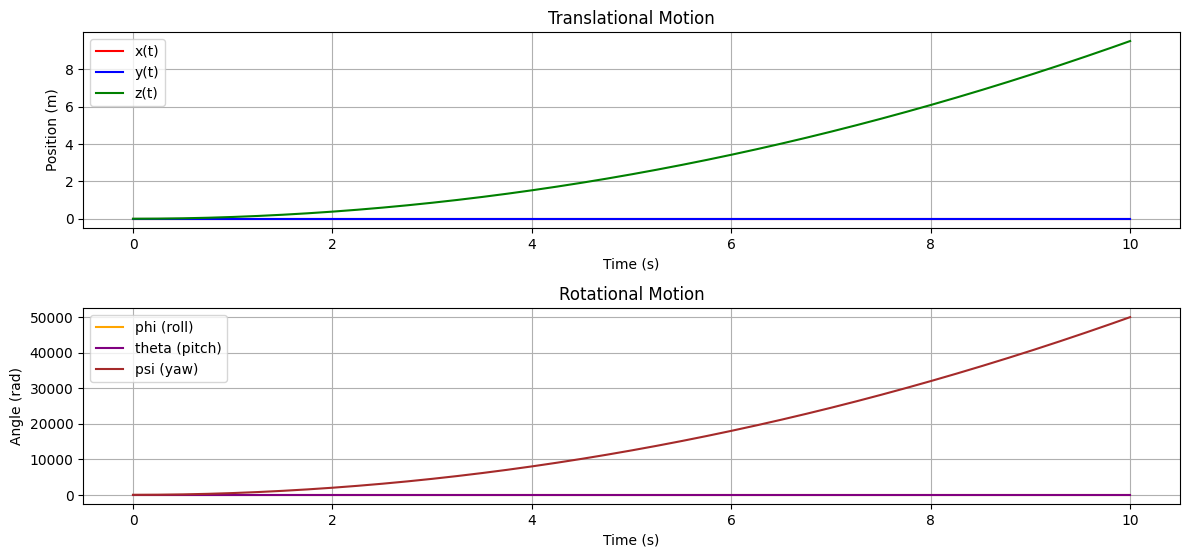

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Constants
m = 1.5  # Mass of the quadcopter (kg)
g = 9.81  # Gravitational acceleration (m/s^2)
I = np.diag([0.02, 0.02, 0.04])  # Moment of inertia (kg·m^2)
T_total = 15.0  # Total thrust (N)
tau = np.array([0.0, 0.00, 40])  # Example torques (Nm)

# Initial conditions: [x, y, z, vx, vy, vz, phi, theta, psi, p, q, r]
initial_conditions = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

# Define the equations of motion
def quadcopter_dynamics(t, state):
    # Unpack state
    x, y, z, vx, vy, vz, phi, theta, psi, p, q, r = state

    # Translational accelerations
    thrust_body = np.array([0, 0, T_total])  # Thrust in body frame
    gravity = np.array([0, 0, -m * g])       # Gravitational force
    R = np.array([  # Rotation matrix (from body to inertial frame)
        [np.cos(theta) * np.cos(psi), np.sin(phi) * np.sin(theta) * np.cos(psi) - np.cos(phi) * np.sin(psi), np.cos(phi) * np.sin(theta) * np.cos(psi) + np.sin(phi) * np.sin(psi)],
        [np.cos(theta) * np.sin(psi), np.sin(phi) * np.sin(theta) * np.sin(psi) + np.cos(phi) * np.cos(psi), np.cos(phi) * np.sin(theta) * np.sin(psi) - np.sin(phi) * np.cos(psi)],
        [-np.sin(theta), np.sin(phi) * np.cos(theta), np.cos(phi) * np.cos(theta)]
    ])
    thrust_inertial = R @ thrust_body
    acc = (thrust_inertial + gravity) / m

    # Rotational accelerations
    omega = np.array([p, q, r])
    omega_dot = np.linalg.inv(I) @ (tau - np.cross(omega, I @ omega))

    # Euler angles rates
    euler_dot = np.array([
        1, np.sin(phi) * np.tan(theta), np.cos(phi) * np.tan(theta),
        0, np.cos(phi), -np.sin(phi),
        0, np.sin(phi) / np.cos(theta), np.cos(phi) / np.cos(theta)
    ]).reshape(3, 3) @ omega

    # Combine derivatives
    derivatives = np.zeros_like(state)
    derivatives[:3] = [vx, vy, vz]         # Velocities
    derivatives[3:6] = acc                # Translational accelerations
    derivatives[6:9] = euler_dot          # Euler angle rates
    derivatives[9:12] = omega_dot         # Rotational accelerations
    return derivatives

# Time range for simulation
t_span = (0, 10)  # Simulate for 10 seconds
t_eval = np.linspace(t_span[0], t_span[1], 1000)  # Time points for evaluation

# Solve the equations
solution = solve_ivp(quadcopter_dynamics, t_span, initial_conditions, t_eval=t_eval, method='RK45')

# Extract results
time = solution.t
x, y, z = solution.y[0], solution.y[1], solution.y[2]
phi, theta, psi = solution.y[6], solution.y[7], solution.y[8]

# Plot the results
plt.figure(figsize=(12, 8))

# Translational motion
plt.subplot(3, 1, 1)
plt.plot(time, x, label='x(t)', color='red')
plt.plot(time, y, label='y(t)', color='blue')
plt.plot(time, z, label='z(t)', color='green')
plt.title('Translational Motion')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.legend()
plt.grid()

# Rotational motion
plt.subplot(3, 1, 2)
plt.plot(time, phi, label='phi (roll)', color='orange')
plt.plot(time, theta, label='theta (pitch)', color='purple')
plt.plot(time, psi, label='psi (yaw)', color='brown')
plt.title('Rotational Motion')
plt.xlabel('Time (s)')
plt.ylabel('Angle (rad)')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

14.715
14.715000100000001
14.715002000000002
14.715002999910002
14.715007999360033
14.715008888098836
14.715009999000078
14.715009999000035
14.715029995000233
14.715039984001233
14.715089919039233
14.715098791177383
14.715109879087397
14.715109879044368
14.715309439286369
14.715408320397366
14.715901759052326
14.715988990704401
14.716097767617622
14.716097724587142
14.718053571002102
14.718942493168782
14.72332021004322
14.7240788280091
14.724964383074111
14.724921335890926
14.732092022652498
14.734029267578451
14.744839980078417
14.748847049780153
14.74952423074204
14.745430999634955
14.747339092860132
14.747020830906951
14.748026303791143
14.751979718195063
14.75090022680482
14.744561351085213
14.74243577890253
14.740687662948575
14.73643983887542
14.742021347613662
14.740602691975774
14.730602364637218
14.72704652752013
14.725568068515235
14.721228605016545
14.725295222343872
14.725361704884449
14.717616618837763
14.71577339044736
14.715468693343247
14.713307372339736
14.71258552253

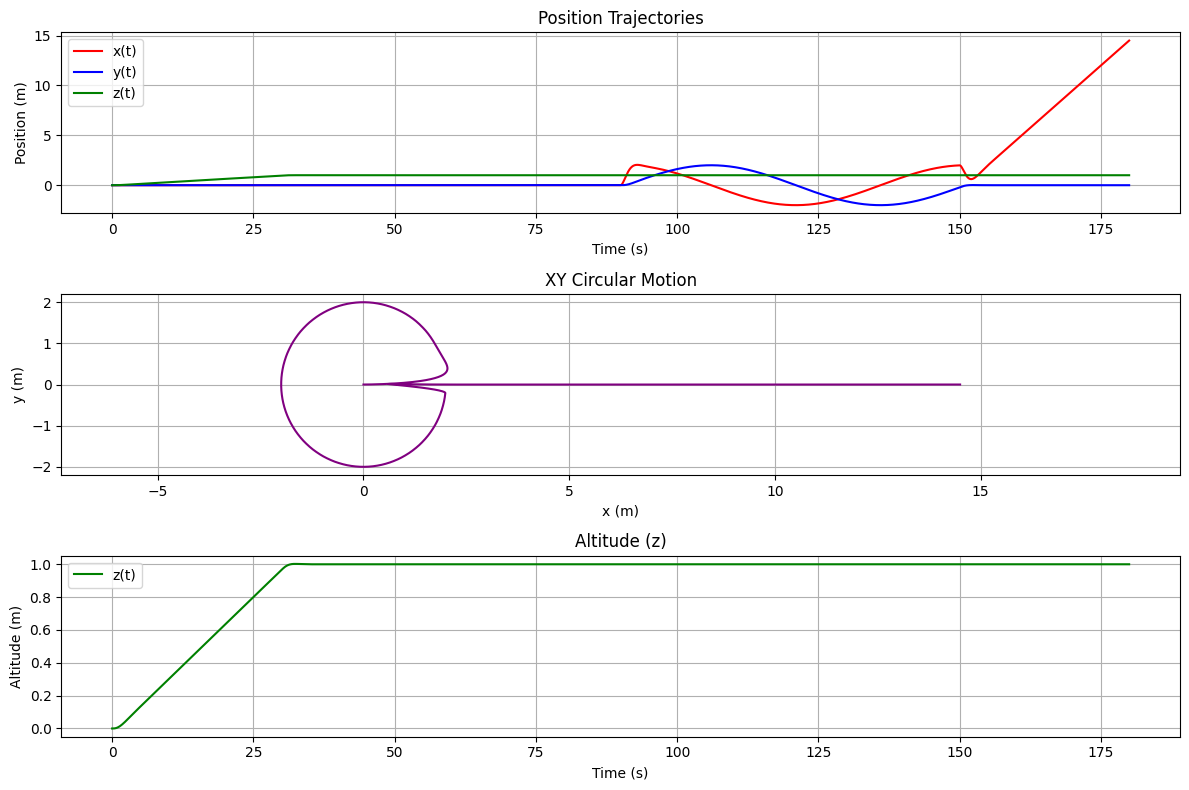

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Constants
m = 1.5  # Mass of the quadcopter (kg)
g = 9.81  # Gravitational acceleration (m/s^2)
I = np.diag([0.02, 0.02, 0.04])  # Moment of inertia (kg·m^2)
RADIUS = 2  # Radius of circular flight (meters)
SPEED_CIRCULAR = 0.5  # Speed for circular flight (m/s)
T_hover = m * g  # Hover thrust

# Initial conditions: [x, y, z, vx, vy, vz, phi, theta, psi, p, q, r]
initial_conditions = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

# Time range for simulation
t_span = (0, 180)  # Simulate for 3 minutes (180 seconds)
t_eval = np.linspace(t_span[0], t_span[1], 5000)

# Define the desired state trajectories
def desired_trajectory(t):
    if t < 30:
        return 0, 0, t / 30  # Linear ascent to 1m
    elif t < 90:
        return 0, 0, 1  # Hover at 1m
    elif t < 150:
        angle = 2 * np.pi * (t - 90) / 60  # Circular motion (1 full circle in 60 seconds)
        return RADIUS * np.cos(angle), RADIUS * np.sin(angle), 1
    else:
        return (t - 150) * SPEED_CIRCULAR, 0, 1  # Linear motion in x-direction

# Quadcopter dynamics
def quadcopter_dynamics(t, state):
    x, y, z, vx, vy, vz, phi, theta, psi, p, q, r = state
    x_des, y_des, z_des = desired_trajectory(t)

    # Position errors
    ex, ey, ez = x_des - x, y_des - y, z_des - z
    evx, evy, evz = -vx, -vy, -vz

    # Control law (PD control)
    k_p, k_d = 10, 5
    k_p, k_d = 2, 2
    ux = k_p * ex + k_d * evx
    uy = k_p * ey + k_d * evy
    uz = k_p * ez + k_d * evz + T_hover / m

    # Convert control forces to thrust and torques
    thrust = m * uz
    print(thrust)
    tau = np.array([0, 0, 0])  # No rotational torques for simplicity

    # Translational accelerations
    acc = np.array([ux, uy, uz - g])

    # Rotational accelerations
    omega = np.array([p, q, r])
    omega_dot = np.linalg.inv(I) @ (tau - np.cross(omega, I @ omega))

    # Euler angles rates
    euler_dot = np.array([
        1, np.sin(phi) * np.tan(theta), np.cos(phi) * np.tan(theta),
        0, np.cos(phi), -np.sin(phi),
        0, np.sin(phi) / np.cos(theta), np.cos(phi) / np.cos(theta)
    ]).reshape(3, 3) @ omega

    # Combine derivatives
    derivatives = np.zeros_like(state)
    derivatives[:3] = [vx, vy, vz]        # Velocities
    derivatives[3:6] = acc                # Translational accelerations
    derivatives[6:9] = euler_dot          # Euler angle rates
    derivatives[9:12] = omega_dot         # Rotational accelerations
    return derivatives

# Solve the equations of motion
solution = solve_ivp(quadcopter_dynamics, t_span, initial_conditions, t_eval=t_eval, method='RK45')

# Extract results
time = solution.t
x, y, z = solution.y[0], solution.y[1], solution.y[2]

# Plot the results
plt.figure(figsize=(12, 8))

# 3D Position plot
plt.subplot(3, 1, 1)
plt.plot(time, x, label='x(t)', color='red')
plt.plot(time, y, label='y(t)', color='blue')
plt.plot(time, z, label='z(t)', color='green')
plt.title('Position Trajectories')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.legend()
plt.grid()

# 2D Projection of Circular Motion
plt.subplot(3, 1, 2)
plt.plot(x, y, label='Path in XY plane', color='purple')
plt.title('XY Circular Motion')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.axis('equal')
plt.grid()

# Altitude
plt.subplot(3, 1, 3)
plt.plot(time, z, label='z(t)', color='green')
plt.title('Altitude (z)')
plt.xlabel('Time (s)')
plt.ylabel('Altitude (m)')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


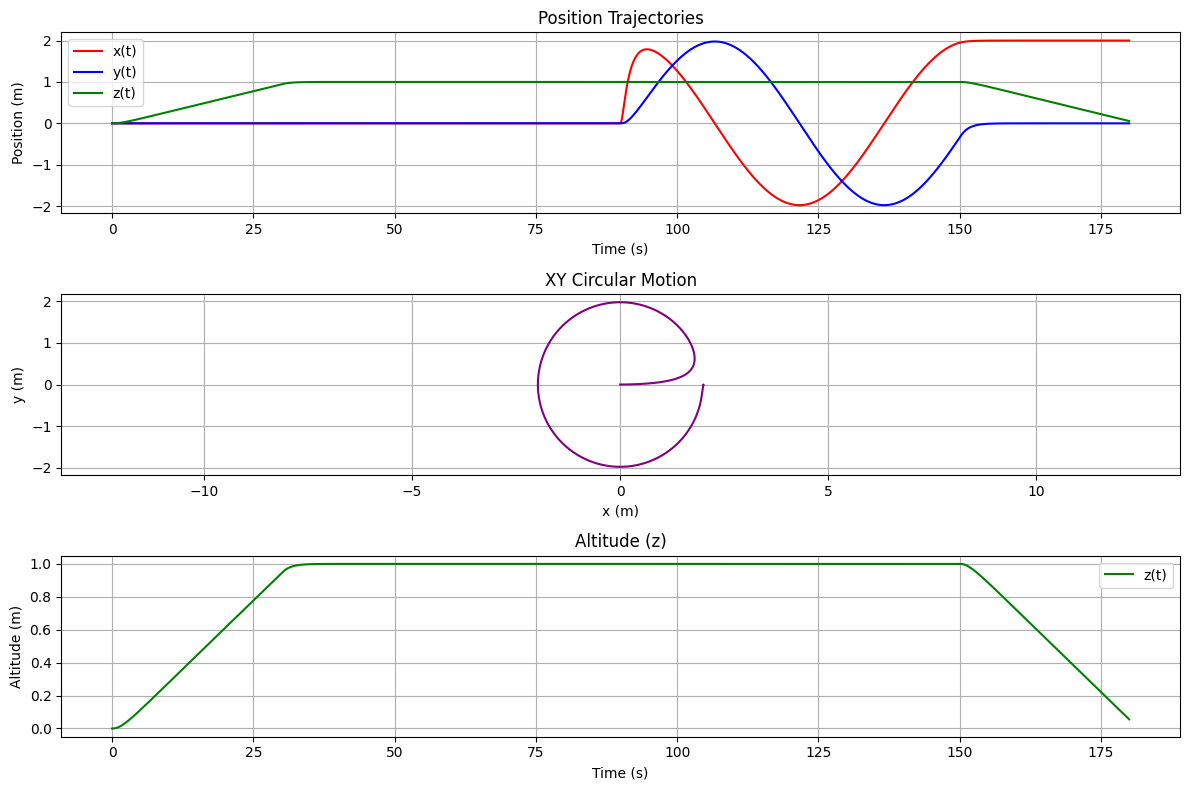

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Constants
m = 1.5  # Mass of the quadcopter (kg)
g = 9.81  # Gravitational acceleration (m/s^2)
I = np.diag([0.02, 0.02, 0.04])  # Moment of inertia (kg·m^2)
RADIUS = 2  # Radius of circular flight (meters)
SPEED_CIRCULAR = 0.5  # Speed for circular flight (m/s)
T_hover = m * g  # Hover thrust

# Initial conditions: [x, y, z, vx, vy, vz, phi, theta, psi, p, q, r]
initial_conditions = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

# Time range for simulation
t_span = (0, 180)  # Simulate for 3 minutes (180 seconds)
t_eval = np.linspace(t_span[0], t_span[1], 1000)

# Define the desired state trajectories
def desired_trajectory(t):
    if t < 30:
        return 0, 0, t / 30  # Linear ascent to 1m
    elif t < 90:
        return 0, 0, 1  # Hover at 1m
    elif t < 150:
        angle = 2 * np.pi * (t - 90) / 60  # Circular motion (1 full circle in 60 seconds)
        return RADIUS * np.cos(angle), RADIUS * np.sin(angle), 1
    elif t < 180:
        return RADIUS, 0, 1 - (t - 150) / 30  # Descend to 0m
    else:
        return RADIUS, 0, 0  # Landed

# Quadcopter dynamics
def quadcopter_dynamics(t, state):
    x, y, z, vx, vy, vz, phi, theta, psi, p, q, r = state
    x_des, y_des, z_des = desired_trajectory(t)

    # Position errors
    ex, ey, ez = x_des - x, y_des - y, z_des - z
    evx, evy, evz = -vx, -vy, -vz

    # Control law (PD control)
    k_p, k_d = 3, 5
    ux = k_p * ex + k_d * evx
    uy = k_p * ey + k_d * evy
    uz = max(0, k_p * ez + k_d * evz + T_hover / m)  # Prevent negative thrust

    # Convert control forces to thrust and torques
    thrust = m * uz
    tau = np.array([0, 0, 0])  # No rotational torques for simplicity

    # Translational accelerations
    acc = np.array([ux, uy, uz - g])

    # Rotational accelerations
    omega = np.array([p, q, r])
    omega_dot = np.linalg.inv(I) @ (tau - np.cross(omega, I @ omega))

    # Euler angles rates
    euler_dot = np.array([
        1, np.sin(phi) * np.tan(theta), np.cos(phi) * np.tan(theta),
        0, np.cos(phi), -np.sin(phi),
        0, np.sin(phi) / np.cos(theta), np.cos(phi) / np.cos(theta)
    ]).reshape(3, 3) @ omega

    # Combine derivatives
    derivatives = np.zeros_like(state)
    derivatives[:3] = [vx, vy, vz]        # Velocities
    derivatives[3:6] = acc                # Translational accelerations
    derivatives[6:9] = euler_dot          # Euler angle rates
    derivatives[9:12] = omega_dot         # Rotational accelerations
    return derivatives

# Solve the equations of motion
solution = solve_ivp(quadcopter_dynamics, t_span, initial_conditions, t_eval=t_eval, method='RK45')

# Extract results
time = solution.t
x, y, z = solution.y[0], solution.y[1], solution.y[2]

# Plot the results
plt.figure(figsize=(12, 8))

# 3D Position plot
plt.subplot(3, 1, 1)
plt.plot(time, x, label='x(t)', color='red')
plt.plot(time, y, label='y(t)', color='blue')
plt.plot(time, z, label='z(t)', color='green')
plt.title('Position Trajectories')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.legend()
plt.grid()

# 2D Projection of Circular Motion
plt.subplot(3, 1, 2)
plt.plot(x, y, label='Path in XY plane', color='purple')
plt.title('XY Circular Motion')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.axis('equal')
plt.grid()

# Altitude
plt.subplot(3, 1, 3)
plt.plot(time, z, label='z(t)', color='green')
plt.title('Altitude (z)')
plt.xlabel('Time (s)')
plt.ylabel('Altitude (m)')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


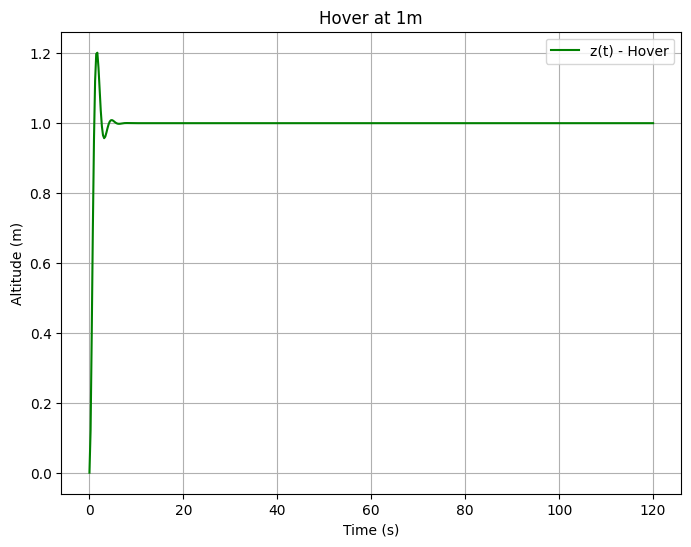

In [ ]:
# Hover dynamics
def hover_dynamics(t, state):
    x, y, z, vx, vy, vz, phi, theta, psi, p, q, r = state

    # Desired hover position
    z_des = 1.0  # 1 meter
    ez = z_des - z
    evz = -vz

    # PD controller
    k_p, k_d = 5, 2
    uz = max(0, k_p * ez + k_d * evz + T_hover / m)  # Prevent negative thrust

    # Translational accelerations
    acc_z = uz - g
    derivatives = np.zeros_like(state)
    derivatives[:3] = [vx, vy, vz]
    derivatives[5] = acc_z  # Only vertical acceleration for hover
    return derivatives

# Time range for hovering
hover_t_span = (0, 120)  # 2 minutes
hover_solution = solve_ivp(hover_dynamics, hover_t_span, initial_conditions, t_eval=np.linspace(0, 120, 500))

# Extract and plot hover results
hover_time = hover_solution.t
hover_z = hover_solution.y[2]

plt.figure(figsize=(8, 6))
plt.plot(hover_time, hover_z, label='z(t) - Hover', color='green')
plt.title('Hover at 1m')
plt.xlabel('Time (s)')
plt.ylabel('Altitude (m)')
plt.grid()
plt.legend()
plt.show()


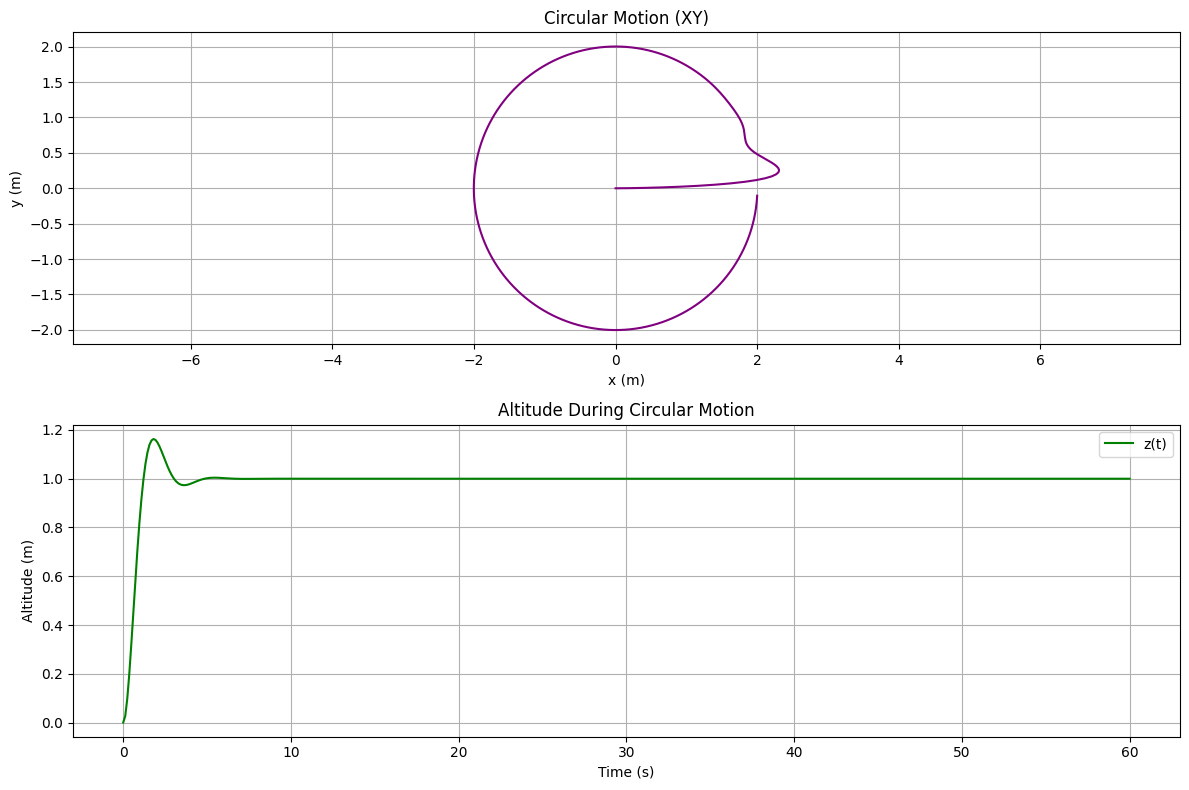

In [ ]:
# Circular motion dynamics
def circular_motion_dynamics(t, state):
    x, y, z, vx, vy, vz, phi, theta, psi, p, q, r = state

    # Desired position (circle)
    angle = 2 * np.pi * (t / 60)  # One full circle in 60 seconds
    x_des = RADIUS * np.cos(angle)
    y_des = RADIUS * np.sin(angle)
    z_des = 1.0  # 1 meter altitude

    # Errors
    ex, ey, ez = x_des - x, y_des - y, z_des - z
    evx, evy, evz = -vx, -vy, -vz

    # PD controller
    k_p, k_d = 4, 2
    ux = k_p * ex + k_d * evx
    uy = k_p * ey + k_d * evy
    uz = max(0, k_p * ez + k_d * evz + T_hover / m)

    # Translational accelerations
    acc = np.array([ux, uy, uz - g])

    derivatives = np.zeros_like(state)
    derivatives[:3] = [vx, vy, vz]
    derivatives[3:6] = acc
    return derivatives

# Time range for circular motion
circular_t_span = (0, 60)  # 1 minute
circular_solution = solve_ivp(circular_motion_dynamics, circular_t_span, initial_conditions, t_eval=np.linspace(0, 60, 500))

# Extract and plot circular motion results
circular_time = circular_solution.t
circular_x = circular_solution.y[0]
circular_y = circular_solution.y[1]
circular_z = circular_solution.y[2]

plt.figure(figsize=(12, 8))

# 2D Circular Path
plt.subplot(2, 1, 1)
plt.plot(circular_x, circular_y, label='XY Path', color='purple')
plt.title('Circular Motion (XY)')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.axis('equal')
plt.grid()

# Altitude Plot
plt.subplot(2, 1, 2)
plt.plot(circular_time, circular_z, label='z(t)', color='green')
plt.title('Altitude During Circular Motion')
plt.xlabel('Time (s)')
plt.ylabel('Altitude (m)')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import plotly.graph_objects as go

# Constants
m = 1.5  # Mass of the quadcopter (kg)
g = 9.81  # Gravitational acceleration (m/s^2)
T_hover = m * g  # Hover thrust
k_p, k_d = 6, 4  # PD controller gains

# Initial conditions: [x, y, z, vx, vy, vz, phi, theta, psi, p, q, r]
initial_conditions = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

# Time range for complex maneuver
t_span = (0, 80)  # Total simulation time
t_eval = np.linspace(t_span[0], t_span[1], 2000)

# Define the trajectory with enforced stops
def complex_trajectory(t):
    if t < 10:  # Ascent to 1m
        return 0, 0, t / 10, 0, 0, 0
    elif t < 20:  # Move 5m in x-direction
        return (t - 10) * 0.5, 0, 1, 0.5, 0, 0
    elif t < 25:  # Hover at 5m, 0m, 1m
        return 5, 0, 1, 0, 0, 0
    elif t < 30:  # Rotate to prepare for y-direction motion
        return 5, 0, 1, 0, 0, 0
    elif t < 40:  # Move 5m in y-direction
        return 5, (t - 30) * 0.5, 1, 0, 0.5, 0
    elif t < 45:  # Hover at 5m, 5m, 1m
        return 5, 5, 1, 0, 0, 0
    else:  # Descend to ground
        return 5, 5, max(0, 1 - (t - 45) / 10), 0, 0, -0.1

# Quadcopter dynamics with explicit stops
def complex_dynamics(t, state):
    x, y, z, vx, vy, vz, phi, theta, psi, p, q, r = state
    x_des, y_des, z_des, vx_des, vy_des, vz_des = complex_trajectory(t)

    # Position and velocity errors
    ex, ey, ez = x_des - x, y_des - y, z_des - z
    evx, evy, evz = vx_des - vx, vy_des - vy, vz_des - vz

    # PD control for forces
    ux = k_p * ex + k_d * evx
    uy = k_p * ey + k_d * evy
    uz = k_p * ez + k_d * evz + T_hover / m

    # Prevent negative thrust
    uz = max(0, uz)

    # Translational accelerations
    acc = np.array([ux, uy, uz - g])

    # Combine derivatives
    derivatives = np.zeros_like(state)
    derivatives[:3] = [vx, vy, vz]  # Velocities
    derivatives[3:6] = acc  # Translational accelerations
    return derivatives

# Solve the equations of motion
solution = solve_ivp(
    complex_dynamics, t_span, initial_conditions, t_eval=t_eval, method="RK45"
)

# Extract results
x = solution.y[0]
y = solution.y[1]
z = solution.y[2]

# Create a 3D interactive plot
fig = go.Figure()

# Plot trajectory
fig.add_trace(
    go.Scatter3d(
        x=x, y=y, z=z, mode="lines", line=dict(color="blue", width=4), name="Trajectory"
    )
)

# Start and end points
fig.add_trace(
    go.Scatter3d(
        x=[x[0], x[-1]],
        y=[y[0], y[-1]],
        z=[z[0], z[-1]],
        mode="markers",
        marker=dict(size=8, color=["green", "red"]),
        name="Start/End",
    )
)

# Add layout details
fig.update_layout(
    title="3D Trajectory of Complex Maneuver (With Explicit Stops)",
    scene=dict(
        xaxis_title="X (m)",
        yaxis_title="Y (m)",
        zaxis_title="Z (m)",
        aspectratio=dict(x=1, y=1, z=0.5),
    ),
    margin=dict(l=0, r=0, b=0, t=40),
)

# Show the plot
fig.show()


In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import plotly.graph_objects as go

# Constants
m = 1.5  # Mass of the quadcopter (kg)
g = 9.81  # Gravitational acceleration (m/s^2)
I = np.diag([0.02, 0.02, 0.04])  # Moment of inertia (kg·m^2)
T_hover = m * g  # Hover thrust
k_p, k_d = 6, 4  # PD controller gains

# Initial conditions: [x, y, z, vx, vy, vz, phi, theta, psi, p, q, r]
initial_conditions = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

# Time range for simulation
t_span = (0, 80)  # Total simulation time
t_eval = np.linspace(t_span[0], t_span[1], 2000)

# Define the trajectory with enforced stops
def complex_trajectory(t):
    if t < 10:  # Ascent to 1m
        return 0, 0, t / 10, 0, 0, 0
    elif t < 20:  # Move 5m in x-direction
        return (t - 10) * 0.5, 0, 1, 0.5, 0, 0
    elif t < 25:  # Hover at 5m, 0m, 1m
        return 5, 0, 1, 0, 0, 0
    elif t < 30:  # Rotate to prepare for y-direction motion
        return 5, 0, 1, 0, 0, 0
    elif t < 40:  # Move 5m in y-direction
        return 5, (t - 30) * 0.5, 1, 0, 0.5, 0
    elif t < 45:  # Hover at 5m, 5m, 1m
        return 5, 5, 1, 0, 0, 0
    else:  # Descend to ground
        return 5, 5, max(0, 1 - (t - 45) / 10), 0, 0, -0.1

# Quadcopter dynamics using Euler-Lagrangian mechanics
def lagrangian_dynamics(t, state):
    x, y, z, vx, vy, vz, phi, theta, psi, p, q, r = state
    x_des, y_des, z_des, vx_des, vy_des, vz_des = complex_trajectory(t)

    # Position and velocity errors
    ex, ey, ez = x_des - x, y_des - y, z_des - z
    evx, evy, evz = vx_des - vx, vy_des - vy, vz_des - vz

    # PD control for forces
    fx = k_p * ex + k_d * evx
    fy = k_p * ey + k_d * evy
    fz = k_p * ez + k_d * evz + T_hover

    # Forces acting on the system
    forces = np.array([fx, fy, fz])

    # Kinetic energy
    T_trans = 0.5 * m * (vx**2 + vy**2 + vz**2)
    T_rot = 0.5 * np.dot([p, q, r], I @ [p, q, r])
    T = T_trans + T_rot

    # Potential energy
    V = m * g * z

    # Lagrangian
    L = T - V

    # Generalized accelerations
    acc = forces / m - np.array([0, 0, g])  # Net translational accelerations

    # Angular accelerations
    omega = np.array([p, q, r])
    tau = np.zeros(3)  # For simplicity, assume zero torques
    omega_dot = np.linalg.inv(I) @ (tau - np.cross(omega, I @ omega))

    # Euler angles rates
    euler_dot = np.array([
        [1, np.sin(phi) * np.tan(theta), np.cos(phi) * np.tan(theta)],
        [0, np.cos(phi), -np.sin(phi)],
        [0, np.sin(phi) / np.cos(theta), np.cos(phi) / np.cos(theta)],
    ]) @ omega

    # Combine derivatives
    derivatives = np.zeros_like(state)
    derivatives[:3] = [vx, vy, vz]        # Velocities
    derivatives[3:6] = acc                # Translational accelerations
    derivatives[6:9] = euler_dot          # Euler angles rates
    derivatives[9:12] = omega_dot         # Rotational accelerations
    return derivatives

# Solve the equations of motion
solution = solve_ivp(
    lagrangian_dynamics, t_span, initial_conditions, t_eval=t_eval, method="RK45"
)

# Extract results
x = solution.y[0]
y = solution.y[1]
z = solution.y[2]

# Create a 3D interactive plot
fig = go.Figure()

# Plot trajectory
fig.add_trace(
    go.Scatter3d(
        x=x, y=y, z=z, mode="lines", line=dict(color="blue", width=4), name="Trajectory"
    )
)

# Start and end points
fig.add_trace(
    go.Scatter3d(
        x=[x[0], x[-1]],
        y=[y[0], y[-1]],
        z=[z[0], z[-1]],
        mode="markers",
        marker=dict(size=8, color=["green", "red"]),
        name="Start/End",
    )
)

# Add layout details
fig.update_layout(
    title="3D Trajectory of Complex Maneuver (Euler-Lagrangian Dynamics)",
    scene=dict(
        xaxis_title="X (m)",
        yaxis_title="Y (m)",
        zaxis_title="Z (m)",
        aspectratio=dict(x=1, y=1, z=0.5),
    ),
    margin=dict(l=0, r=0, b=0, t=40),
)

# Show the plot
fig.show()


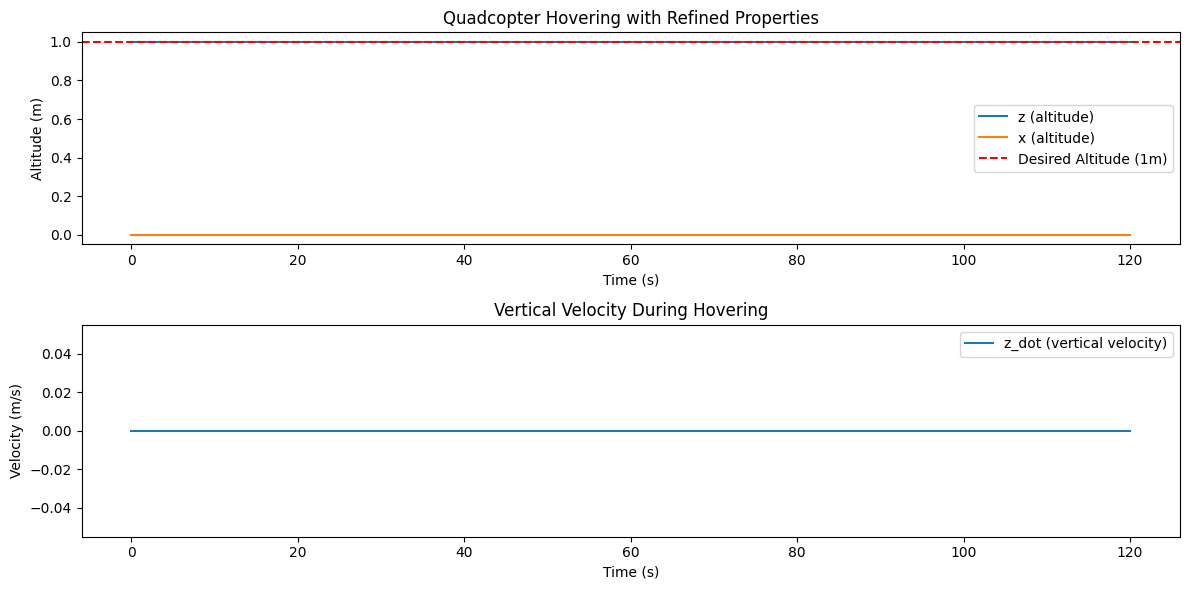

1.0

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
# Refined properties for the quadcopter to balance weight and achieve stable hovering
m = 1.0       # mass of the quadcopter (kg)
kt = 1e-3     # thrust coefficient (adjusted for realistic values)
g = 9.81      # gravity (m/s^2)

z_desired = 1.0

# Compute updated motor speeds required for hovering
w_hover = np.sqrt((m * g) / (4 * kt))  # Hovering angular velocity (rad/s)
w1, w2, w3, w4 = w_hover, w_hover, w_hover, w_hover  # Equal motor speeds for hovering

# Refined dynamics for hovering
def quadcopter_dynamics_refined(t, state):
    # Unpack the state vector
    x, x_dot, y, y_dot, z, z_dot, phi, phi_dot, theta, theta_dot, psi, psi_dot = state

    # Compute total thrust from motors
    T = kt * (w1**2 + w2**2 + w3**2 + w4**2)

    # Translational accelerations
    x_ddot = T/m * (np.cos(psi) * np.sin(theta) * np.cos(phi) + np.sin(psi) * np.sin(phi))
    y_ddot = T/m * (np.sin(psi) * np.sin(theta) * np.cos(phi) - np.cos(psi) * np.sin(phi))
    z_ddot = T/m * (np.cos(theta) * np.cos(phi)) - g

    # Rotational accelerations (no orientation control, assume stable hover)
    phi_ddot = 0
    theta_ddot = 0
    psi_ddot = 0

    # State derivatives
    return [x_dot, x_ddot, y_dot, y_ddot, z_dot, z_ddot,
            phi_dot, phi_ddot, theta_dot, theta_ddot, psi_dot, psi_ddot]

# Refined initial state: start close to the desired altitude
initial_state_refined = [0, 0, 0, 0, 1.0, 0, 0, 0, 0, 0, 0, 0]  # Initial z = 1m
# Time span and evaluation points
time_span = (0, 120)  # simulate for 2 minutes
time_eval = np.linspace(0, 120, 1000)

# Simulate for hovering with refined dynamics
solution_refined = solve_ivp(quadcopter_dynamics_refined, time_span, initial_state_refined, t_eval=time_eval, rtol=1e-5, atol=1e-8)

# Extract results
time = solution_refined.t
x, x_dot, y, y_dot, z, z_dot, phi, phi_dot, theta, theta_dot, psi, psi_dot = solution_refined.y

# Plot results for refined hovering
plt.figure(figsize=(12, 6))

# Altitude plot
plt.subplot(2, 1, 1)
plt.plot(time, z, label="z (altitude)")
plt.plot(time, x, label = "x (altitude)")
plt.axhline(y=z_desired, color='r', linestyle='--', label="Desired Altitude (1m)")
plt.xlabel("Time (s)")
plt.ylabel("Altitude (m)")
plt.legend()
plt.title("Quadcopter Hovering with Refined Properties")

# Vertical velocity plot
plt.subplot(2, 1, 2)
plt.plot(time, z_dot, label="z_dot (vertical velocity)")
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.legend()
plt.title("Vertical Velocity During Hovering")

plt.tight_layout()
plt.show()

# Display final altitude to verify hovering
final_altitude_refined = z[-1]
final_altitude_refined


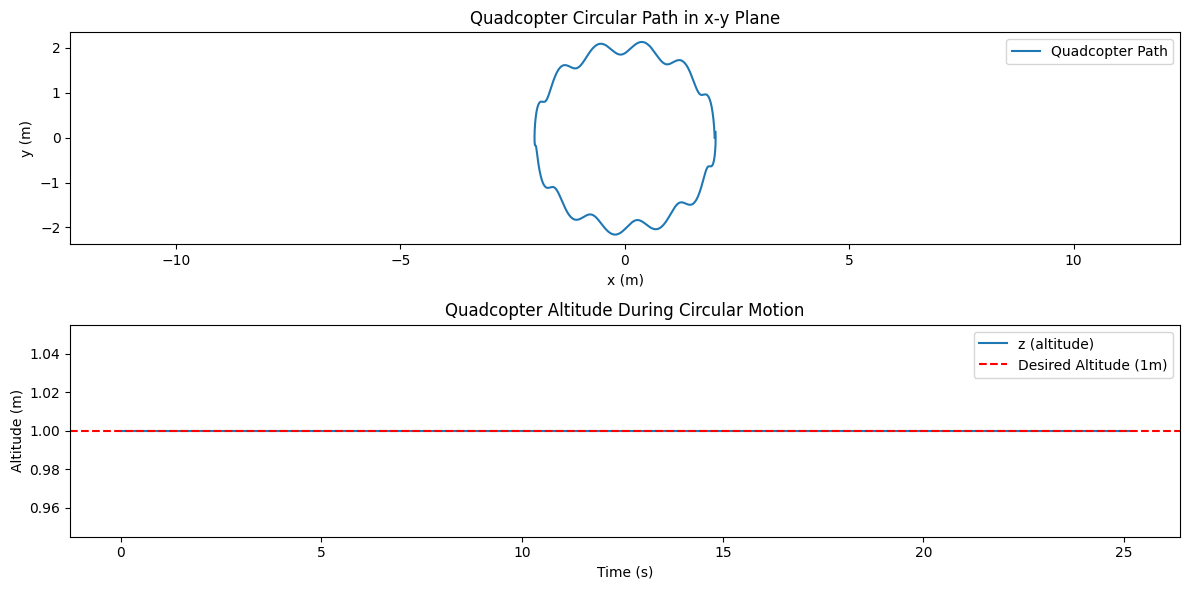

In [ ]:
# Constants for circular trajectory
radius = 2.0  # Radius of the circle (m)
speed = 0.5   # Speed along the circular path (m/s)
altitude = 1.0  # Altitude above ground (m)

# Time for one full circle
circle_time = 2 * np.pi * radius / speed  # Time to complete one circle

# Redefine time span for this performance goal
time_span_circle = (0, circle_time)  # Simulate for one circle duration
time_eval_circle = np.linspace(0, circle_time, 1000)

# Generate the circular trajectory (desired path)
def generate_circular_trajectory(t, radius, speed):
    x_desired = radius * np.cos(speed * t / radius)  # x-coordinate
    y_desired = radius * np.sin(speed * t / radius)  # y-coordinate
    return x_desired, y_desired

# Dynamics for tracking the circular path
def quadcopter_dynamics_circular(t, state):
    # Unpack the state vector
    x, x_dot, y, y_dot, z, z_dot, phi, phi_dot, theta, theta_dot, psi, psi_dot = state

    # Desired positions (from trajectory)
    x_desired, y_desired = generate_circular_trajectory(t, radius, speed)

    # Control laws for position tracking (simplified proportional control)
    Kp_xy = 10.0  # Proportional gain for x and y
    Kp_z = 10.0   # Proportional gain for z

    # Compute thrust and torques to track desired trajectory
    x_error = x_desired - x
    y_error = y_desired - y
    z_error = altitude - z  # Desired altitude

    # Thrust components
    T_x = Kp_xy * x_error
    T_y = Kp_xy * y_error
    T_z = m * g + Kp_z * z_error  # Include gravity compensation for altitude

    # Total thrust (simplified for control, no orientation changes)
    T = np.sqrt(T_x**2 + T_y**2 + T_z**2)

    # Translational accelerations
    x_ddot = T_x / m
    y_ddot = T_y / m
    z_ddot = T_z / m - g

    # Rotational accelerations (assume stable hover, no complex dynamics)
    phi_ddot = 0
    theta_ddot = 0
    psi_ddot = 0

    # State derivatives
    return [x_dot, x_ddot, y_dot, y_ddot, z_dot, z_ddot,
            phi_dot, phi_ddot, theta_dot, theta_ddot, psi_dot, psi_ddot]

# Initial state: Start at (radius, 0) on the circular path, z = altitude
initial_state_circle = [radius, 0, 0, 0, altitude, 0, 0, 0, 0, 0, 0, 0]

# Simulate for circular motion
solution_circle = solve_ivp(
    quadcopter_dynamics_circular,
    time_span_circle,
    initial_state_circle,
    t_eval=time_eval_circle,
    rtol=1e-5,
    atol=1e-8
)

# Extract results
time_circle = solution_circle.t
x_circle, x_dot_circle, y_circle, y_dot_circle, z_circle, z_dot_circle = solution_circle.y[:6]

# Plot results for circular motion
plt.figure(figsize=(12, 6))

# Circular path in x-y plane
plt.subplot(2, 1, 1)
plt.plot(x_circle, y_circle, label="Quadcopter Path")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title("Quadcopter Circular Path in x-y Plane")
plt.axis("equal")
plt.legend()

# Altitude plot
plt.subplot(2, 1, 2)
plt.plot(time_circle, z_circle, label="z (altitude)")
plt.axhline(y=altitude, color='r', linestyle='--', label="Desired Altitude (1m)")
plt.xlabel("Time (s)")
plt.ylabel("Altitude (m)")
plt.title("Quadcopter Altitude During Circular Motion")
plt.legend()

plt.tight_layout()
plt.show()


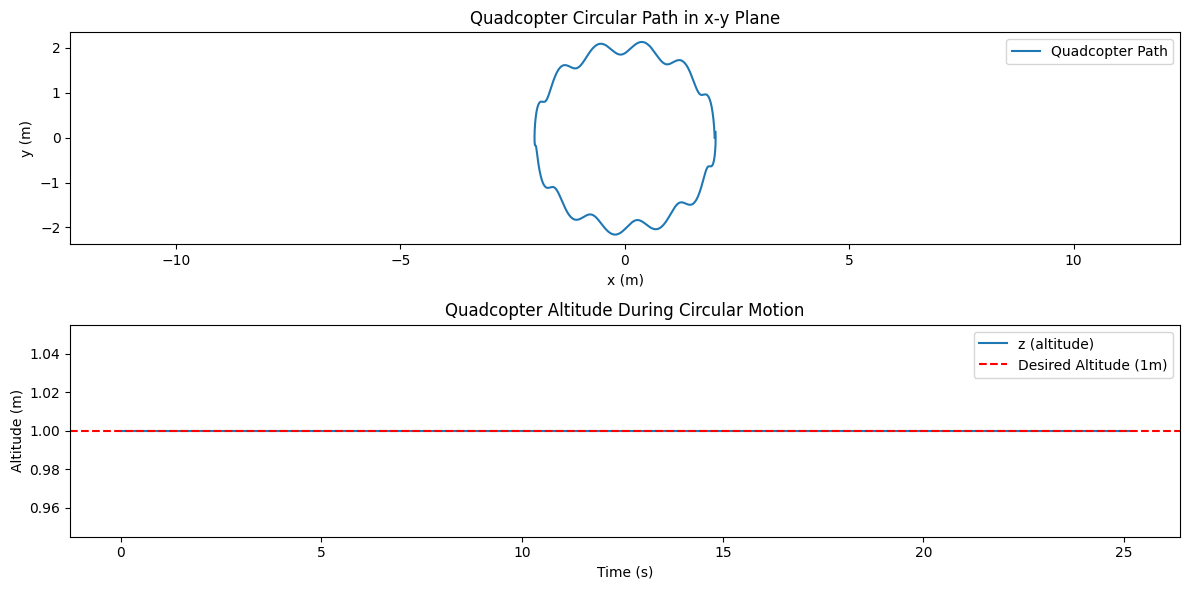

In [ ]:
# Constants for circular trajectory
radius = 2.0  # Radius of the circle (m)
speed = 0.5   # Speed along the circular path (m/s)
altitude = 1.0  # Altitude above ground (m)

# Time for one full circle
circle_time = 2 * np.pi * radius / speed  # Time to complete one circle

# Redefine time span for this performance goal
time_span_circle = (0, circle_time)  # Simulate for one circle duration
time_eval_circle = np.linspace(0, circle_time, 1000)

# Generate the circular trajectory (desired path)
def generate_circular_trajectory(t, radius, speed):
    x_desired = radius * np.cos(speed * t / radius)  # x-coordinate
    y_desired = radius * np.sin(speed * t / radius)  # y-coordinate
    return x_desired, y_desired

# Dynamics for tracking the circular path
def quadcopter_dynamics_circular(t, state):
    # Unpack the state vector
    x, x_dot, y, y_dot, z, z_dot, phi, phi_dot, theta, theta_dot, psi, psi_dot = state

    # Desired positions (from trajectory)
    x_desired, y_desired = generate_circular_trajectory(t, radius, speed)

    # Control laws for position tracking (simplified proportional control)
    Kp_xy = 10.0  # Proportional gain for x and y
    Kp_z = 10.0   # Proportional gain for z

    # Compute thrust and torques to track desired trajectory
    x_error = x_desired - x
    y_error = y_desired - y
    z_error = altitude - z  # Desired altitude

    # Thrust components
    T_x = Kp_xy * x_error
    T_y = Kp_xy * y_error
    T_z = m * g + Kp_z * z_error  # Include gravity compensation for altitude

    # Total thrust (simplified for control, no orientation changes)
    T = np.sqrt(T_x**2 + T_y**2 + T_z**2)

    # Translational accelerations
    x_ddot = T_x / m
    y_ddot = T_y / m
    z_ddot = T_z / m - g

    # Rotational accelerations (assume stable hover, no complex dynamics)
    phi_ddot = 0
    theta_ddot = 0
    psi_ddot = 0

    # State derivatives
    return [x_dot, x_ddot, y_dot, y_ddot, z_dot, z_ddot,
            phi_dot, phi_ddot, theta_dot, theta_ddot, psi_dot, psi_ddot]

# Initial state: Start at (radius, 0) on the circular path, z = altitude
initial_state_circle = [radius, 0, 0, 0, altitude, 0, 0, 0, 0, 0, 0, 0]

# Simulate for circular motion
solution_circle = solve_ivp(
    quadcopter_dynamics_circular,
    time_span_circle,
    initial_state_circle,
    t_eval=time_eval_circle,
    rtol=1e-5,
    atol=1e-8
)

# Extract results
time_circle = solution_circle.t
x_circle, x_dot_circle, y_circle, y_dot_circle, z_circle, z_dot_circle = solution_circle.y[:6]

# Plot results for circular motion
plt.figure(figsize=(12, 6))

# Circular path in x-y plane
plt.subplot(2, 1, 1)
plt.plot(x_circle, y_circle, label="Quadcopter Path")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title("Quadcopter Circular Path in x-y Plane")
plt.axis("equal")
plt.legend()

# Altitude plot
plt.subplot(2, 1, 2)
plt.plot(time_circle, z_circle, label="z (altitude)")
plt.axhline(y=altitude, color='r', linestyle='--', label="Desired Altitude (1m)")
plt.xlabel("Time (s)")
plt.ylabel("Altitude (m)")
plt.title("Quadcopter Altitude During Circular Motion")
plt.legend()

plt.tight_layout()
plt.show()
